In [1]:
import numpy as np 
import scipy as sp 
import matplotlib.pyplot as plt
import pandas as pd
from osc_toolkit import oscillation, delayed_oscillation
from models import *
from functools import partial
from jitcdde import jitcdde, y, t, jitcdde_input
import ipywidgets as widgets

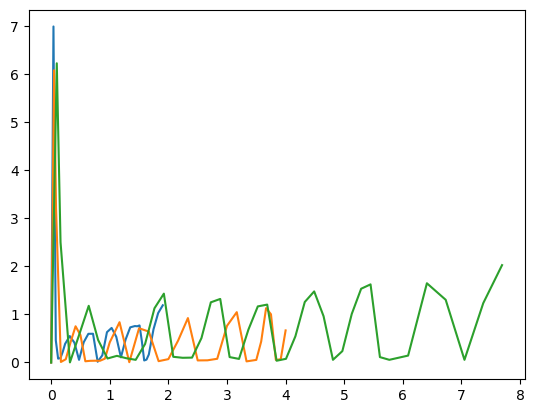

In [2]:
files = [r'Data_sets\3a_fig3b_25_osc_NatChem_MH.csv', r'Data_sets\3a_fig3b_50_osc_NatChem_MH.csv', r'Data_sets\3a_fig3b_101_osc_NatChem_MH.csv']

df_MH_NatChem_fig3b_25, df_MH_NatChem_fig3b_50, df_MH_NatChem_fig3b_101 = [pd.read_csv(file) for file in files]
df_list = [df_MH_NatChem_fig3b_25, df_MH_NatChem_fig3b_50, df_MH_NatChem_fig3b_101]

cA2_tol = 14.5
CMC_3a = 1.56
tau = [2.1, 1, 0.52]

for tau, df in zip(tau, df_list):
    df['c3a'] /= CMC_3a
    df['Time'] /= tau
    df['t'] /= tau

for df in df_list:
    plt.plot(df['Time'], df['c3a'])

In [3]:
params = np.array([36, 51, 0.55, 20.4])
consts = np.array([0.11, 2])
delay = np.array([0.02, 0.045])
init_cond = np.array([0.9, 0])
delayed_model_50 = delayed_oscillation(delayed_approx_model_FTC, delay, params, consts, init_cond, calc_all_delayed_approx_model_FTC)

In [4]:
delayed_model_50.add_exp_data(df_MH_NatChem_fig3b_50)

The species are ['A2', 'S_sum', 'A', 'O']. Please check if the data is in the same order and correct format (time, concentration).


Generating, compiling, and loading C code.
Using default integration parameters.


(<Figure size 500x500 with 2 Axes>,
 array([<Axes: xlabel='Normalized Time', ylabel='Normalized Concentration'>,
        <Axes: xlabel='Normalized Time', ylabel='Normalized Concentration'>],
       dtype=object))

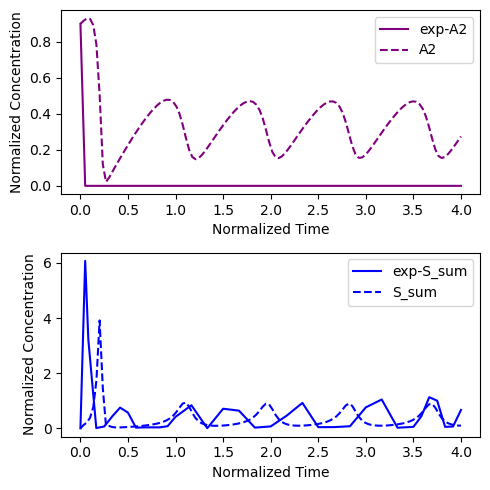

In [8]:
delayed_model_50.set_delay([0.02, 0.04])
delayed_model_50.plot(exp=True)

In [9]:
delayed_model_50.interactive_plot(exp=True, ran=30)

interactive(children=(FloatSlider(value=36.0, description='alpha', max=66.0, min=6.0, step=0.05), FloatSlider(…